In [1]:
using Distributions
using LinearAlgebra
using StatsBase: ecdf, Histogram
using StatsPlots
default(fmt=:png)

(a, b, c, d) = (10, 6, 5, 12)
pval = min(1, 2 * (ecdf(diff))(-0.01), 2 * (1 - (ecdf(diff))(-0.01))) = 0.04599
pointestimate = quantile(diff, 1 / 2) = 0.3234776702890394
lower = quantile(diff, 0.05 / 2) = -0.004174483047251563
upper = quantile(diff, 1 - 0.05 / 2) = 0.6069934431223969
[lower, upper] = [-0.004174483047251563, 0.6069934431223969]


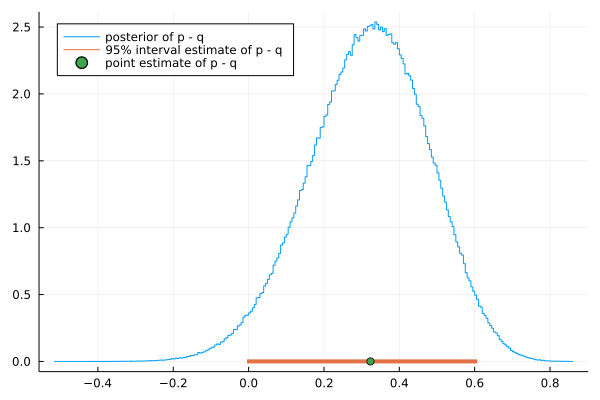

In [2]:
A = [
    10  6
     5 12
]
a, b, c, d = A'
@show a, b, c, d

# 事後分布
# quantile(diff, 1/2) を点推定値としたい場合には "1/3" を採用するとよい.
posterior_p = Beta(a+1/3, b+1/3)
posterior_q = Beta(c+1/3, d+1/3)

# 事後分布の乱数を大量生成
p = rand(posterior_p, 10^6)
q = rand(posterior_q, 10^6)

# 事後分布で生成したpとqの差を計算
diff = p - q

# 仮説 p - q = -0.01 のP値
@show pval = min(1, 2ecdf(diff)(-0.01), 2(1-ecdf(diff)(-0.01)))

# p - q の点推定
@show pointestimate = quantile(diff, 1/2)

# p - q の区間推定
@show lower = quantile(diff, 0.05/2)
@show upper = quantile(diff, 1 - 0.05/2)
@show [lower, upper]

stephist(diff; norm=true, label="posterior of p - q")
plot!([lower, upper], zeros(2); label="95% interval estimate of p - q", lw=4)
scatter!([pointestimate], zeros(1); label="point estimate of p - q", ls=:dash)
plot!(legend=:topleft)

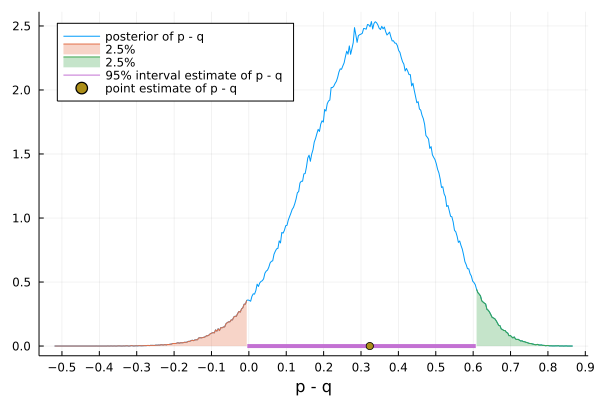

In [3]:
h = fit(Histogram, diff, range(minimum(diff)-0.01, maximum(diff)+0.01, 401))
x = (h.edges[1][begin+1:end] + h.edges[1][begin:end-1])/2
dx = h.edges[1][begin+1:end] - h.edges[1][begin:end-1]
y = h.weights ./ length(diff) ./ dx
plot(x, y; label="posterior of p - q")
i_L = findlast(≤(lower), x)
i_U = findfirst(>(upper), x)
plot!(x[begin:i_L], y[begin:i_L]; label="2.5%", fillrange=0, fa=0.3)
plot!(x[i_U:end], y[i_U:end]; label="2.5%", fillrange=0, fa=0.3)
plot!([lower, upper], zeros(2); label="95% interval estimate of p - q", lw=4)
scatter!([pointestimate], zeros(1); label="point estimate of p - q", ls=:dash)
plot!(xtick=-1:0.1:1, xguide="p - q")
plot!(legend=:topleft)

In [4]:
function bayes2x2(a, b, c, d;
        diff0=0, ratio0=1, oddsratio0=1, 
        L=10^6, prior=(1//3, 1//3), alpha=0.05)
    s, t = prior
    posterior_p, posterior_q = Beta(a+s, b+t), Beta(c+s, d+t)
    p, q = rand(posterior_p, L), rand(posterior_q, L)
    
    diff = @. p - q
    ecdf_diff = ecdf(diff)
    pvalue_diff = min(1, 2ecdf_diff(diff0), 2(1-ecdf_diff(diff0)))
    diff_lower = quantile(diff, alpha/2)
    diff_pointest = quantile(diff, 1/2)
    diff_upper = quantile(diff, 1-alpha/2)

    ratio = @. p / q
    ecdf_raito = ecdf(ratio)
    pvalue_ratio = min(1, 2ecdf_raito(ratio0), 2(1-ecdf_raito(ratio0)))
    ratio_lower = quantile(ratio, alpha/2)
    ratio_pointest = quantile(ratio, 1/2)
    ratio_upper = quantile(ratio, 1-alpha/2)
    
    oddsratio = @. (p/(1 - p)) / (q/(1 - q))
    ecdf_oddsratio = ecdf(oddsratio)
    pvalue_oddsratio = min(1, 2ecdf_oddsratio(oddsratio0), 2(1-ecdf_oddsratio(oddsratio0)))
    oddsratio_lower = quantile(oddsratio, alpha/2)
    oddsratio_pointest = quantile(oddsratio, 1/2)
    oddsratio_upper = quantile(oddsratio, 1-alpha/2)
    
    (;  a, b, c, d, diff0, ratio0, oddsratio0, L, prior, alpha,
        pvalue_diff, diff_lower, diff_pointest, diff_upper,
        pvalue_ratio, ratio_lower, ratio_pointest, ratio_upper,
        pvalue_oddsratio, oddsratio_lower, oddsratio_pointest, oddsratio_upper)
end

function show_bayes2x2(result)
    (;  a, b, c, d, diff0, ratio0, oddsratio0, L, prior, alpha,
        pvalue_diff, diff_lower, diff_pointest, diff_upper,
        pvalue_ratio, ratio_lower, ratio_pointest, ratio_upper,
        pvalue_oddsratio, oddsratio_lower, oddsratio_pointest, oddsratio_upper) = result
    println("data: [$a $b; $c $d]")
    println("prior: $prior")
    println("method: Monte Carlo with $L iterations")
    println()
    println("p-value of hypothesis p - q = $diff0:  $(100pvalue_diff)%")
    println("point estimate of p - q:  ", diff_pointest)
    println("$(100(1-alpha))% credible interval of p - q:  ", [diff_lower, diff_upper])
    println()
    println("p-value of hypothesis p / q = $ratio0:  $(100pvalue_ratio)%")
    println("point estimate of p/q:  ", ratio_pointest)
    println("$(100(1-alpha))% credible interval of p/q:  ", [ratio_lower, ratio_upper])
    println()
    println("p-value of hypothesis (p(1-p))/(q(1-q)) = $oddsratio0:  $(100pvalue_oddsratio)%")
    println("point estimate of (p(1-p))/(q(1-q)):  ", oddsratio_pointest)
    println("$(100(1-alpha))% credible interval of (p(1-p))/(q(1-q)):  ", [oddsratio_lower, oddsratio_upper])
end

A = [
    10  6
     5 12
]
a, b, c, d = A'
result = bayes2x2(a, b, c, d; diff0=-0.01, ratio0=0.99, oddsratio0=0.99)
show_bayes2x2(result)

data: [10 6; 5 12]
prior: (1//3, 1//3)
method: Monte Carlo with 1000000 iterations

p-value of hypothesis p - q = -0.01:  4.5536%
point estimate of p - q:  0.32418191871767477
95.0% credible interval of p - q:  [-0.0031067234334784706, 0.60804338996473]

p-value of hypothesis p / q = 0.99:  4.903%
point estimate of p/q:  2.0998213736012294
95.0% credible interval of p/q:  [0.9931594036869225, 5.485381737459639]

p-value of hypothesis (p(1-p))/(q(1-q)) = 0.99:  5.0444%
point estimate of (p(1-p))/(q(1-q)):  4.060907130072724
95.0% credible interval of (p(1-p))/(q(1-q)):  [0.9871277139075947, 18.852518097220333]
